In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1uJ-dv3bs5iCgEgIe3dILw7kEhAktldzz' 


download = drive.CreateFile({'id': file_id})
#import image files from Google Drive

# Download the file to a local disc
download.GetContentFile('images.zip')

In [2]:
from zipfile import ZipFile
with ZipFile('images.zip', 'r') as zipImage:
    zipImage.extractall()


In [3]:

import pandas as pd
import os
import numpy as np
folder_path = os.getcwd() + '/images/'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [4]:
num_classes = 2

In [7]:
#!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 463 kB 4.8 MB/s 
     |████████████████████████████████| 1.3 MB 74.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [5]:
#Import Tensorflow and Keras library 
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2

Data Preprocessing

In [6]:
print(tf.__version__)

2.7.0


In [8]:
#Read the dataset images and preprocess the them using cv2. Images are resized to 224x224.  
img_size = 224

train_data = []
test_data = []
for folder in os.listdir(folder_path):
    print(folder)
    if folder =='training':
        print(os.path.join(folder_path, folder, ""))
        for train_folder in os.listdir(os.path.join(folder_path, folder)):                                      
            for pic in os.listdir(os.path.join(folder_path, folder, train_folder, "")):
                current_path = os.path.join(folder_path, folder, train_folder, "")
                image_path = current_path + pic 
                #print(image_path)
                if train_folder == 'flip':
                    ground_truth = 1
                else: 
                    ground_truth = 0
                img_arr = cv2.imread(image_path)[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                train_data.append([resized_arr, ground_truth])
    elif folder =='testing':
        for test_folder in os.listdir(os.path.join(folder_path, folder)):                                      
            for pic in os.listdir(os.path.join(folder_path, folder, test_folder, "")):
                current_path = os.path.join(folder_path, folder, test_folder, "")
                image_path = current_path + pic 
                #print(image_path)
                if test_folder == 'flip':
                    ground_truth = 1
                else: ground_truth = 0
                img_arr = cv2.imread(image_path)[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                test_data.append([resized_arr, ground_truth])


train_data = np.array(train_data)
test_data = np.array(test_data)

testing
training
/content/images/training/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


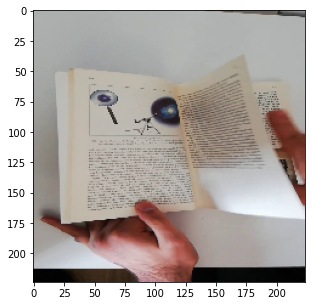

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train_data[0][0])

In [10]:
x_train = []
y_train = []
x_test = []
y_test = []
for feature, label in train_data:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test_data:
  x_test.append(feature)
  y_test.append(label)




In [11]:

# Normalize the image colour to the range 0 to 1
x_train = np.array(x_train) / 255

x_test = np.array(x_test) / 255


y_train = np.array(y_train)

y_test = np.array(y_test)

Keras CNN model

In [12]:
#Build a Keras model with 3 convolutional layers. Each convolutional layer is followed by a Max Pooling layer.
#We use dropout rate of 0.3 to avoid overfitting. A fully connected layer is used to link up the flatten layer and only output will be produced by the model.
#We choose sigmoid as our activation function in the last layer since we want to have a single output with a range from 0 to 1.
#The output lower than 0.5 would be predicted as 'Not Flipped' and the one with higher than 0.5 would be predicted as 'Flipped'
model = Sequential()
model.add(Conv2D(16, 3,padding="same", strides=(1,1), activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(16, 3, padding="same", strides=(1,1), activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", strides=(1,1), activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [13]:
opt = adam_v2.Adam(learning_rate=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [14]:
x_train.shape

(2392, 224, 224, 3)

In [15]:
#The model is trained for 50 epochs with 16 samples for each batch.
#20% of sample from train set would be used as validation set 
batch_size = 16
history = model.fit(x_train, y_train, epochs = 50 ,batch_size = batch_size, validation_split = 0.2, shuffle=True)
model.save_weights('model.h5')

Epoch 1/50
120/120 [==============================] - 16s 26ms/step - loss: 0.6219 - accuracy: 0.6675 - val_loss: 0.9785 - val_accuracy: 0.2902
Epoch 2/50
120/120 [==============================] - 2s 17ms/step - loss: 0.4682 - accuracy: 0.7904 - val_loss: 0.2801 - val_accuracy: 0.9478
Epoch 3/50
120/120 [==============================] - 2s 17ms/step - loss: 0.2909 - accuracy: 0.9012 - val_loss: 0.1041 - val_accuracy: 0.9770
Epoch 4/50
120/120 [==============================] - 2s 17ms/step - loss: 0.2012 - accuracy: 0.9326 - val_loss: 0.2445 - val_accuracy: 0.8998
Epoch 5/50
120/120 [==============================] - 2s 17ms/step - loss: 0.1604 - accuracy: 0.9451 - val_loss: 0.1357 - val_accuracy: 0.9541
Epoch 6/50
120/120 [==============================] - 2s 17ms/step - loss: 0.1207 - accuracy: 0.9566 - val_loss: 0.1345 - val_accuracy: 0.9436
Epoch 7/50
120/120 [==============================] - 2s 17ms/step - loss: 0.0950 - accuracy: 0.9665 - val_loss: 0.1036 - val_accuracy: 0.960

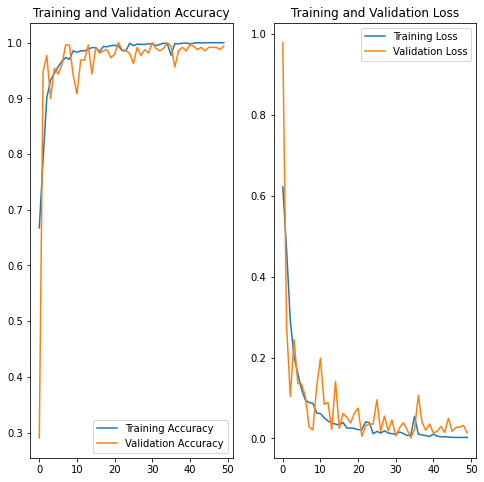

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#From the figure above we can see that the model converages quickly in less than 50 epochs. It produces a result with more than 90% accuracy. 

In [17]:
#Let's see how well the model does on the test set.
predictions = model.predict(x_test)
pred = [0 if x < 0.5 else 1 for x in predictions]
print(classification_report(y_test, pred, target_names = ['Not Flip (0)','Flip (1)']))

              precision    recall  f1-score   support

Not Flip (0)       0.99      1.00      1.00       307
    Flip (1)       1.00      0.99      0.99       290

    accuracy                           0.99       597
   macro avg       1.00      0.99      0.99       597
weighted avg       1.00      0.99      0.99       597



In [ ]:
#The model has almost 100% overall accuracy and can predict all images with no flipping action 

The image includes NotFlip(0)/Flip(1): 1


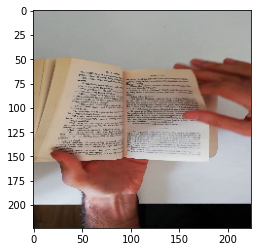

<Figure size 360x360 with 0 Axes>

In [18]:
plt.imshow(test_data[0][0])
plt.figure(figsize = (5,5))
print('The image includes NotFlip(0)/Flip(1):', pred[0] )